In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import lightning as L

import cv2

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Параметры

In [2]:
import warnings
warnings.filterwarnings('ignore')   #Trainer любит негодовать

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 4
epoch_num = 6


data_folder = "data/"

ab_path   = data_folder + "ab1.npy"
L_path    = data_folder + "gray_scale.npy"
tags_path = data_folder + "tags.npy"
wti_path  = data_folder + "words_to_inds.npy"
save_path = data_folder + "saves/cwgan_gp.pth"

# Вспомогательные Функции

In [35]:
def show_input_data(L, ab, tags, index):   #не брезгуем передавать массивы, т.к. они передаются по ссылке
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    img = np.zeros( (224, 224, 3) )
    img[:, :, 0] = L[index]
    plt.title("Gray Scale")
    plt.imshow(img[:,:,0], cmap='gray')

    plt.axis('off')


    plt.subplot(1, 2, 2)
    img[:, :, 1:] = ab[index]
    img = img.astype('uint8')
    img_col = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title("Colored")
    plt.imshow(img_col)

    plt.axis('off')

    plt.show()
    print( *tags[index].split()[:8] )



def convert_to_Lab(L_chan, ab_chan):
    """
      т.к. при использоваии загрузчика данных значчения тензоров отображаются в сегмент [0, 1]
        необходима функция, которая уже обработанные тензоры переведёт обратно:
              L:   [0, 1] -> [0, 100];
              a,b: [0, 1] -> [-128, 127]

        (данные берутся из загрузчика и обрабатываются до конкатенации)
        (обрабатывается батч данных, это важно для указания dim=1 (это индекс) (в батче может быть и только 1 картинка))
    """
    L_chan = L_chan*100
    ab_chan = ab_chan*255 - 128   # 0->-128; 1->127
    Lab_chan = torch.cat( [L_chan, ab_chan], dim=1)
    Lab_chan = Lab_chan.permute(0, 2, 3, 1)
    Lab_chan = Lab_chan.numpy()

    return Lab_chan



def compare_result(gray, real_ab, gened_ab, tags, ind=0):
    plt.figure(figsize=(12, 8))

    gray = gray.detach().cpu()
    real_ab = real_ab.detach().cpu()
    gened_ab = gened_ab.detach().cpu()

    real_show_b = convert_to_Lab(gray, real_ab)
    gened_show_b = convert_to_Lab(gray, gened_ab)
    gray_show = gray[ind].permute(1, 2, 0).numpy() * 100   #процесс перевода в тензор изображения меняет местами
                                                           # разрешение изображения и каналы - надо вернуть как было
                                                           # 224х224х3 -(ToTensor())-> 3x224x224 -(pretmute(...))-> 224x224x3
                                                           #   (для остальных массивов преобразование сделано в convert_to_Lab() )

    real_show = real_show_b[ind]
    gened_show = gened_show_b[ind]
    real_show = cv2.cvtColor(real_show, cv2.COLOR_LAB2RGB)
    gened_show = cv2.cvtColor(gened_show, cv2.COLOR_LAB2RGB)

    ##  Серая  ##
    plt.subplot(1, 3, 1)
    plt.title("Gray Scale")
    plt.imshow(gray_show, cmap='gray')

    plt.axis('off')


    ##  Цветная(ориг.)  ##
    plt.subplot(1, 3, 2)
    plt.title("Colored")
    plt.imshow(real_show)

    plt.axis('off')


    ##  Цветная(сген.)  ##
    plt.subplot(1, 3, 3)
    plt.title("Gened")
    plt.imshow(gened_show)

    plt.axis('off')

    plt.show()
    tags_back_to_words = [inds_to_words[token.item()] for token in tags[ind] ]
    print( " ".join(tags_back_to_words) )


# Загрузка данных

In [4]:
ab_data = np.load(ab_path)[0:5000]
L_data = np.load(L_path)[:5000]
tags_data = np.load(tags_path)[:5000]

In [5]:
words_to_inds = np.load(wti_path, allow_pickle='TRUE').item()
inds_to_words = {ind:word for word, ind in words_to_inds.items()}
    #пригодится, если захотим во время обучения прочитать для проверки теги
    #т.к. по построению `words_to_inds` было биективным отображением,
    # проблем с обратным словарём не будет
vocab_size = len(words_to_inds)

In [6]:
words_to_inds[''], inds_to_words[0]

(0, '')

In [7]:
ab_data.shape, L_data.shape, tags_data.shape

((5000, 224, 224, 2), (5000, 224, 224), (5000,))

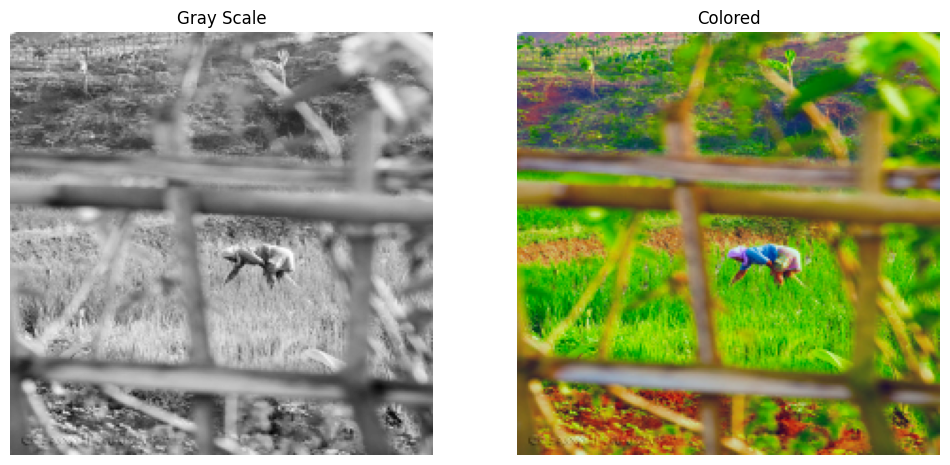

farmer cisauk ricefield d300 18200vr nikkor teeje serpong


In [8]:
show_input_data(L_data, ab_data, tags_data, 99)

# Создание датасета

In [9]:
class ColorizDataset(Dataset):
    def __init__(self, L_data, ab_data, tags_data,
                 words_to_inds, tag_num=8, transform=None):
        self.L = L_data
        self.ab = ab_data
        self.tag_num = tag_num
        self.tags = self.prepare_tags(tags_data)
        
        self.transform = transform
        self.wti = words_to_inds
    
    
    def prepare_tags(self, tags_data):
        '''
        Для каждой строки, состоящей из тегов берём первые `tag_num` штук
          и переводим с помощью `words_to_inds` в соответствующие им индексы.
        После этого случаи с < 8 кол-вом тегов дополняются 0-ми (сщщтветствует
          символу '' - отсутствие тега)
        '''
        encoded_tags = [torch.tensor( [words_to_inds[word] for word in tag_row.split()[:self.tag_num]] )
                            for tag_row in tags_data]
        padded_tags = pad_sequence(encoded_tags, batch_first=True, padding_value=0)
        
        return padded_tags
    
    def __getitem__(self, ind):
        L_ind = self.L[ind]
        L_ind = self.transform(L_ind)

        ab_ind = self.ab[ind]
        ab_ind = self.transform(ab_ind)
        
        tag_ind = self.tags[ind]

        return L_ind, ab_ind, tag_ind

    def __len__(self):
        return len(self.L)


transform = transforms.ToTensor()
dataset = ColorizDataset(L_data, ab_data, tags_data,
                         words_to_inds, transform=transform)

In [10]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=False)

In [9]:
## можно проверить вид внешних данных из загрузчика:
#dataiter = iter(train_loader)
#images_gray, images_ab, images_tags = next(dataiter)
#print( images_gray.shape,  images_ab.shape, images_tags.shape)
#print( torch.max(images_gray), torch.min(images_gray), torch.max(images_ab), torch.min(images_ab))
#print(images_tags)
## -> значения L,ab лежат в диапазоне [0, 1]

# Создание класса Нейронной сети

## Вспомогательные функции для генератора

In [11]:
###  для генератора

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Skipping Connection (Identity Mapping)
        self.conv_for_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride)

  
    def forward(self, x):
        identity = x.clone()

        x = self.block(x)
        identity = self.conv_for_skip(identity)

        output = x + identity
        output = F.relu(output)
        return output


## вниз
class UEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UEncoder, self).__init__()

        self.down_layer = nn.Sequential(
            nn.MaxPool2d(2, 2),
            ResBlock(in_channels, out_channels, stride=stride)
        )

    def forward(self, x):
        output = self.down_layer(x)
        return output


## вверх
class UDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UDecoder, self).__init__()

        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.residual_block = ResBlock(in_channels+out_channels, out_channels)      #потому что перед Conv2d происходит конкатенация с identity (skip)
  
    def forward(self, x, skip):
        x = self.upsamp(x)

        x = torch.cat( [x, skip], dim=1)

        output = self.residual_block(x)
        return output

    
    
## обработка тегов к виду входных данных
##   (batch_size, 8) --> (batch_size, 1, 224, 224)
# отдельным классом, т.к. процесс будет идентичен и в генераторе, и в критике
class Embedding_tags(nn.Module):
    def __init__(self, cond_channels=1, vocab_size=vocab_size, emb_dim=4):
        super(Embedding_tags, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
            #(b_s, 8) -> (b_s, 8, emb_dim)
        self.lstm = nn.LSTM(emb_dim, 32, num_layers=2, batch_first=True)
            #(b_s, 8, emb_dim) -> (b_s, 8, 32)
        self.lin1 = nn.Linear(32, 14*14)
            #(b_s, 8, 32) -> (b_s, 8, 14*14)
        self.lin2 = nn.Linear(14*14, 56*56)
            #(b_s, 8, 14*14) -> (b_s, 8, 56*56)
            
        #then in forward reshape to -> (b_s, 8, 56, 56)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            #(b_s, 8, 56, 56) -> (b_s, 8, 112, 112)
        self.conv1 = nn.Conv2d(8, 4, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 8, 112, 112) -> (b_s, 4, 112, 112)
        #upsample again:
            #(b_s, 4, 112, 112) -> (b_s, 4, 224, 224)
        self.conv2 = nn.Conv2d(4, cond_channels, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 4, 224, 224) -> (b_s, 1, 224, 224)
        #желаемая размерность получена
    
    def forward(self, x):
        x = self.emb(x)
        x, _ = self.lstm(x)
        x = self.lin1(x)
        x = self.lin2(x)
        x = x.view(-1, 8, 56, 56)
        x = self.up(x)
        x = self.conv1(x)
        x = self.up(x)
        output = self.conv2(x)
        
        return output

## Сам Генератор

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size, emb_dim=4, dropout_rate=0.5):
        super(Generator, self).__init__()
        
        ## обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        ## 2 первых слоя конволюции перед началом ResNet'a
        self.enc_layer0 = ResBlock(in_channels+cond_channels, 64)
            #in_channels - изначальные входные данные
            # + cond_channels  - приконкатеннированные условия

        ## спускаемся вниз по U-Net'у
        self.enc_layer1 = UEncoder(64, 128)
        self.enc_layer2 = UEncoder(128, 256)

        ## "центральная" часть (мост)
        self.bridge = UEncoder(256, 512)

        ## возвращаемся к первоначчальным размерам
        self.dec_layer2 = UDecoder(512, 256)
        self.dec_layer1 = UDecoder(256, 128)
        self.dec_layer0 = UDecoder(128, 64)

        ## переводим необходимое нам кол-во каналов в качестве output генератора
        ##   (получили 1 канал: L; на выходе 2 канала: a,b)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)

        # применяется после Conv2d для меньшей зависимости между каналами feature maps
        self.drop = nn.Dropout2d(dropout_rate)

  
    def forward(self, x, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        #конкатенируем входные данные и условия
        x = torch.cat( [x, conds], dim=1)
        
        # спуск вниз
        e0 = self.enc_layer0(x)   #разные буквы, так как нам нужны skip connections
        e0 = self.drop(e0)   #skip №0
        e1 = self.enc_layer1(e0)
        e1 = self.drop(e1)   #skip №1
        e2 = self.enc_layer2(e1)
        e2 = self.drop(e2)   #skip №2

        # мостик
        b = self.bridge(e2)
        b = self.drop(b)

        # обратно
        d2 = self.dec_layer2(b, e2)
         #d2 = self.drop(d2)    возможно, при увелечении размерности, это не необходимо
        d1 = self.dec_layer1(d2,e1)
         #d1 = self.drop(d1)
        d0 = self.dec_layer0(d1, e0)

        output = self.output(d0)
        return output


In [13]:
check_model = Generator(1,2,1,vocab_size).to(device)
#help(summary)
summary(check_model,
        [(1, 1, 224, 224), (1, 8)],
        batch_dim = None,
        dtypes=[torch.float, torch.int],
        depth=3,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding_tags: 1-1                    [1, 1, 224, 224]          --
|    └─Embedding: 2-1                    [1, 8, 4]                 245,740
|    └─LSTM: 2-2                         [1, 8, 32]                13,312
|    └─Linear: 2-3                       [1, 8, 196]               6,468
|    └─Linear: 2-4                       [1, 8, 3136]              617,792
|    └─Upsample: 2-5                     [1, 8, 112, 112]          --
|    └─Conv2d: 2-6                       [1, 4, 112, 112]          288
|    └─Upsample: 2-7                     [1, 4, 224, 224]          --
|    └─Conv2d: 2-8                       [1, 1, 224, 224]          36
├─ResBlock: 1-2                          [1, 64, 224, 224]         --
|    └─Sequential: 2-9                   [1, 64, 224, 224]         --
|    |    └─Conv2d: 3-1                  [1, 64, 224, 224]         1,152
|    |    └─BatchNorm2d: 3-2             [1, 64, 224, 224]      

## Критик (Дискриминатор)

In [14]:
##from torch.nn.modules.instancenorm import InstanceNorm2d
# простенькая cnn: на выходе размерность 1, чем больше число,
#   тем вероятнее, по мнению критика, что картинка настоящая (не сгенерирована)
class Critic(nn.Module):
    def __init__(self, in_channels=3, cond_channels=1,
                 vocab_size=vocab_size, emb_dim=4):
        super(Critic, self).__init__()
        
        # обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        self.discrim = nn.Sequential(
            # 224x224 - размеры картинки (без feature maps)
            nn.Conv2d(in_channels+cond_channels, 64, kernel_size=5, stride=2, padding=0),   #110x110
                #in_channels - изначальные входные данные (1-L, 2-ab => 3)
                # + 1  - приконкатеннированные условия
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   #55x55
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(128, 256, kernel_size=7, stride=2, padding=0),  #25x25
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(256, 512, kernel_size=5, stride=3, padding=1),  #8x8
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.3, inplace=True),

            nn.AdaptiveAvgPool2d(1), #1x1
            nn.Flatten(),
            nn.Linear(512, 1)  #512 features maps -> 1 скалярный вывод
        )
  
  
    def forward(self, l, ab, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        x = torch.cat( (l, ab, conds), dim=1)

        output = self.discrim(x)
        return output


In [15]:
check_model = Critic(3,1, vocab_size).to(device)
summary(check_model,
        [(1, 1, 224, 224), (1, 2, 224, 224), (1, 8)],
        batch_dim = None,
        dtypes=[torch.float, torch.float, torch.int],
        depth=3,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding_tags: 1-1                    [1, 1, 224, 224]          --
|    └─Embedding: 2-1                    [1, 8, 4]                 245,740
|    └─LSTM: 2-2                         [1, 8, 32]                13,312
|    └─Linear: 2-3                       [1, 8, 196]               6,468
|    └─Linear: 2-4                       [1, 8, 3136]              617,792
|    └─Upsample: 2-5                     [1, 8, 112, 112]          --
|    └─Conv2d: 2-6                       [1, 4, 112, 112]          288
|    └─Upsample: 2-7                     [1, 4, 224, 224]          --
|    └─Conv2d: 2-8                       [1, 1, 224, 224]          36
├─Sequential: 1-2                        [1, 1]                    --
|    └─Conv2d: 2-9                       [1, 64, 110, 110]         6,464
|    └─LeakyReLU: 2-10                   [1, 64, 110, 110]         --
|    └─Conv2d: 2-11                      [1, 128, 55, 55]       

## Воедино

In [50]:
class cWGAN_GP(L.LightningModule):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size=vocab_size, emb_dim=4,
                 lr=0.0001, n_critic=5, lambda_gp=11):
        super(cWGAN_GP, self).__init__()
        
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(in_channels, out_channels, cond_channels,
                                   vocab_size, dropout_rate=0.2)
        self.critic = Critic(in_channels+out_channels, cond_channels,
                             vocab_size)

        self.lambda_gp = lambda_gp
        self.n_critic = n_critic
        self.apply(self.custom_init_weights)

  
    def custom_init_weights(self, m):
        '''
            weights следует быть небольшими, поэтому предлагается после каждого спуска
              по градиенту переводить значения в условный отрезок [-0.01, 0.01],
            поэтому изначально нет смысла в больших значениях 
            (https://arxiv.org/pdf/1701.07875v3.pdf, стр. 7)
        '''
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)):
            #torch.nn.init.normal_(m.weight, 0.0, 0.01)
            m.weight.data.normal_(mean=0.0, std=0.01)
            if m.bias is not None:
                m.bias.data.zero_()


    def configure_optimizers(self):
        learning_rate = self.hparams.lr

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        opt_c = torch.optim.Adam(self.critic.parameters(), lr=learning_rate)
        return [opt_g, opt_c], []

    
    def forward(self, z, conds):
        return self.generator(z, conds)
    
    
    
    def gradient_penalty(self, gray, real, fake, conds):
        alpha = torch.rand( (real.shape[0], 1, 1, 1), requires_grad=True ).to(device)
        interpolated_images = real*alpha + fake*(1-alpha)

        #calculate critic scores
        mixed_scores = self.critic(gray, interpolated_images, conds)
        
        
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores), #wich size grads would be
            create_graph=True,
            retain_graph=True
        )[0]
        # - computing the gradient of the `mixed_scores` w.r.t. `interpolated_images`

        
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1) #L2-norm

        gradient_penalty = torch.mean( (gradient_norm - 1)**2 )

        return gradient_penalty
        


    def training_step(self, batch, batch_idx):
        gray, real_ab, conds = batch   #батч имеет вид: (L канал, ab канал, вектор тегов)
        self.current_batch = [gray, real_ab, conds]  
            #сохраним батч, чтобы в конце ипока нарисовать прогресс сети

        optimizer_g, optimizer_c = self.optimizers()

        
        ###  тренеруем Генератор  ###
         #self.toggle_optimizer(optimizer_g)

        fake_ab = self(gray, conds)
        fake_ab = fake_ab.type_as(gray)  #если батч находится на gpu, переместим сгенерированные изображения туда же
        
        fake_score = self.critic(gray, fake_ab, conds)
        g_loss = -torch.mean( fake_score )   #берём среднее от результатов критика по генерирукмым данным со знаком минус,
                                             #   т.к. loss изначально подразумевается к уменьшению, 
                                             #    а правдоподобность картинки пропорциональна выводу критика => надо увеличить

        optimizer_g.zero_grad()   
        self.manual_backward(g_loss)
        optimizer_g.step()

         #self.untoggle_optimizer(optimizer_g)
        ###  конец тренеровки Генератора  ###


        ###  тренеруем Критика  ###
         #self.toggle_optimizer(optimizer_c)

        for repeats in range(self.n_critic):
            #для WGAN рекомендовано, чтобы на 1 тренировочный шаг генератора
            #   приходилось несколько шагов критика (предлагаемое знач. = 5)


            #нужно проверить два условия:
            #   1)входные real_ab помечены, как правдаподобные
            #   2)сгенерированные fake_ab помечены, как неправдаподобные
            #        (но fake_ab должны быть сгенерированы заново, т.к. генератор был немного изменён внутри training_step )
            fake_ab = self(gray, conds).detach()   #но генератор обновляться уже не будет -> .detach()
            fake_ab = fake_ab.type_as(gray)

            real_loss = self.critic(gray, real_ab, conds)
            fake_loss = self.critic(gray, fake_ab, conds)
            gp = self.gradient_penalty(gray, real_ab, fake_ab, conds)

            c_loss = -( torch.mean(real_loss) - torch.mean(fake_loss) ) + self.lambda_gp*gp

            optimizer_c.zero_grad()
            self.manual_backward(c_loss)
            optimizer_c.step()

         #self.untoggle_optimizer(optimizer_c)
        ###  конец тренеровки Критика  ###



    def on_train_epoch_end(self):
        #каждый n-ый epoch выводим
        n = 5
        torch.save(self.state_dict(), save_path)
        if ( (self.current_epoch) % n == 0):
            print(f'\nEpoch №{self.current_epoch}')
            gray, ab, tags = self.current_batch
            compare_result(gray, ab, self(gray, tags).detach(), tags)



In [51]:
cwgan_gp = cWGAN_GP(in_channels=1, out_channels=2, cond_channels=1,
            vocab_size=vocab_size, lr=0.0001, lambda_gp=11)
#for name, param in wgan.named_parameters():
#  print(f'{name}: {param}')

# Если надо загрузить

In [18]:
cwgan_gp.load_state_dict(torch.load(save_path))
##wgan.train();

# Тренируем

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | generator | Generator | 9.1 M 
1 | critic    | Critic    | 5.9 M 
----------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
60.022    Total estimated model params size (MB)


Epoch 0: 100%|███████████████████████████████████████████████████████████| 1250/1250 [30:28<00:00,  1.46s/it, v_num=17]Epoch №0


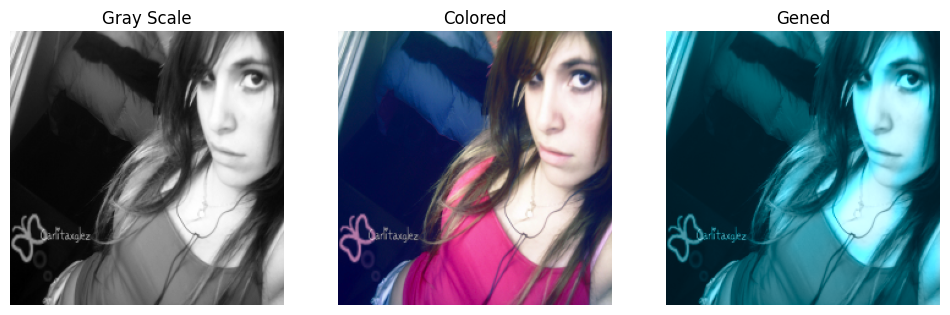

       
Epoch 5: 100%|███████████████████████████████████████████████████████████| 1250/1250 [30:42<00:00,  1.47s/it, v_num=17]Epoch №5


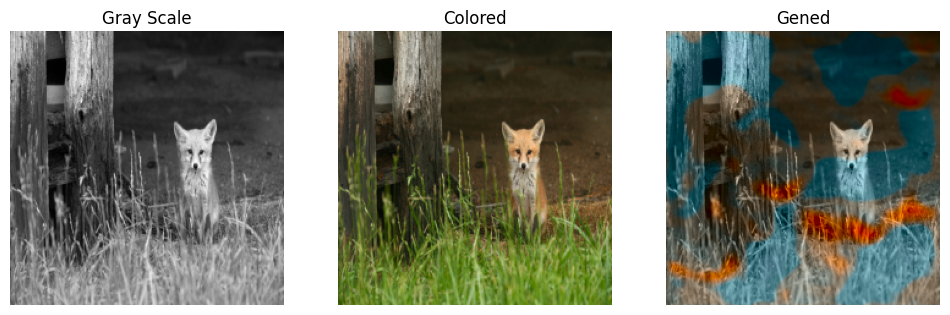

fox foxes animalbabies babyfox mammalia mammals carnivores ferocious


`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|███████████████████████████████████████████████████████████| 1250/1250 [30:44<00:00,  1.48s/it, v_num=17]


In [52]:
trainer = L.Trainer(max_epochs=epoch_num, accelerator="auto")
trainer.fit(cwgan_gp, train_loader)

# Всё посмотрели, понравилось, берём

In [67]:
torch.save(cwgan_gp.state_dict(), save_path)
#на всякий случай?
torch.save(cwgan_gp.generator.state_dict(), data_folder + 'saves/generator.pth')
torch.save(cwgan_gp.critic.state_dict(),    data_folder + 'saves/critic.pth')

# Доп проверка и пр.

In [23]:
test_iter = iter(test_loader)

In [25]:
gray, real, tags = next(test_iter)
generated = cwgan_gp(gray, tags).detach()

In [27]:
generated.min()

tensor(0.7933)

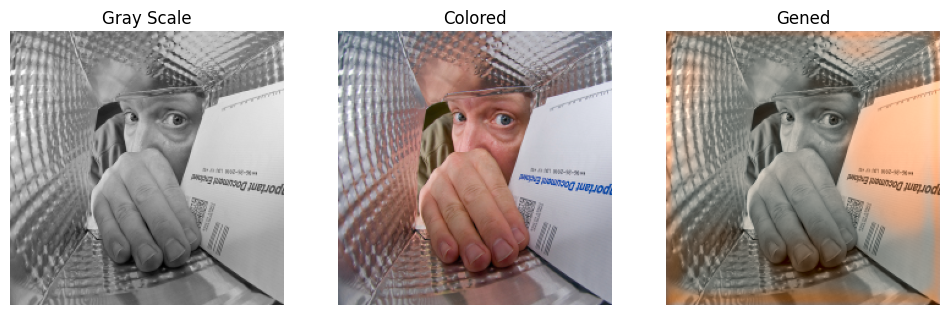

macromondays macro mailbox fisheye letter self portrait explore


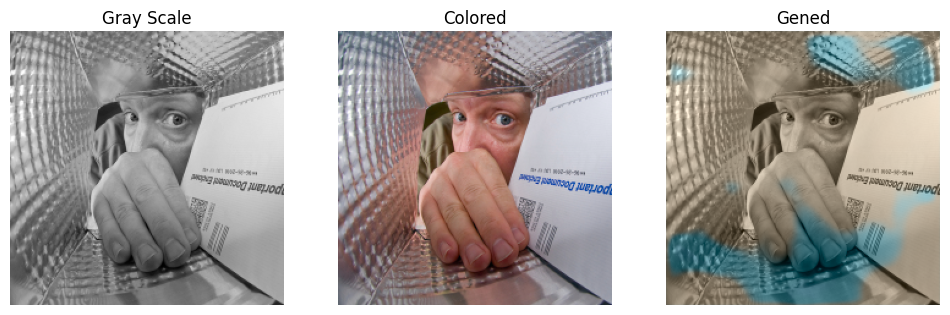

macromondays macro mailbox fisheye letter self portrait explore


In [84]:
compare_result(gray, real, generated, tags)
compare_result(gray, real, cwgan_gp(gray, tags).detach(), tags)

In [54]:
## test load
test_model = cWGAN_GP(in_channels=1, out_channels=2, cond_channels=1,
            vocab_size=vocab_size, lr=1, lambda_gp=1)

In [56]:
test_model.lambda_gp

1

In [63]:
#test_model.state_dict()
test_model.generator.emb.emb.weight

Parameter containing:
tensor([[-1.2908e+00,  9.1776e-01, -5.0497e-01, -1.6397e+00],
        [-1.9683e-01, -3.0291e-01,  1.0768e+00,  2.1640e+00],
        [ 1.1333e+00,  6.2831e-01,  1.1930e+00, -6.0922e-04],
        ...,
        [-5.1839e-01,  5.1993e-01,  9.5302e-01,  9.0438e-01],
        [-1.3067e+00, -7.1151e-01, -2.4329e-01, -3.3893e-01],
        [-1.8915e+00,  6.2543e-01, -5.2196e-01, -1.3668e+00]],
       requires_grad=True)

In [73]:
test_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [74]:
test_model.lambda_gp, cwgan_gp.lambda_gp

(1, 11)

In [75]:
test_model.generator.emb.emb.weight

Parameter containing:
tensor([[-1.7646,  1.1509, -0.6890, -0.8544],
        [ 0.8184,  0.5522,  1.5118, -0.3288],
        [-0.2154, -0.5827, -0.6541, -1.4855],
        ...,
        [-2.3984, -0.6817,  0.6498, -0.8239],
        [-0.1162, -1.2541,  0.7434,  0.2970],
        [-1.7300,  1.9103,  0.2025,  0.4550]], requires_grad=True)

In [82]:
(test_model.generator.emb.emb.weight == cwgan_gp.generator.emb.emb.weight).prod()

tensor(1)

In [85]:
#test_model.state_dict()